In [1]:
%matplotlib inline

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
import seaborn as sns

import histlite as hl
import csky as cy

from glob import glob
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots.mplstyle')

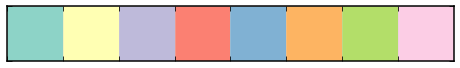

In [66]:
sns.palplot(sns.color_palette("Set3", 8))

In [75]:
sns.choose_colorbrewer_palette('qualitative', n=9, desat=0.5)

TypeError: choose_colorbrewer_palette() got an unexpected keyword argument 'n'

In [3]:
trials_path = '/home/apizzuto/Nova/python3/scripts/stacking_sens_res/'

In [50]:
delta_ts = np.logspace(1., 5.5, 10)
gammas = np.array([2.0, 2.5, 3.0])

results = {gamma: list(map(lambda t, gamma: np.load(trials_path + 'delta_t_{:.2e}_gamma_{}.pkl'.format(t, gamma),
                                        allow_pickle=True), delta_ts, np.ones_like(delta_ts)*gamma)) 
                                        for gamma in gammas}
sensitivity = {gamma: np.array([results[gamma][ii]['E2dNdE'] for ii in np.r_[0:len(results[gamma]):1]]) 
                                       for gamma in gammas}
event_sensitivity = {gamma: np.array([results[gamma][ii]['n_sig'] for ii in np.r_[0:len(results[gamma]):1]]) 
                                       for gamma in gammas}

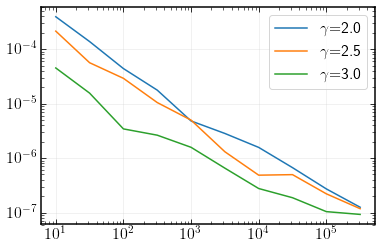

In [51]:
for gamma in gammas:
    plt.plot(delta_ts, sensitivity[gamma] / delta_ts, label = f"$\gamma$={gamma}")
    
plt.loglog()
plt.legend()
plt.show()

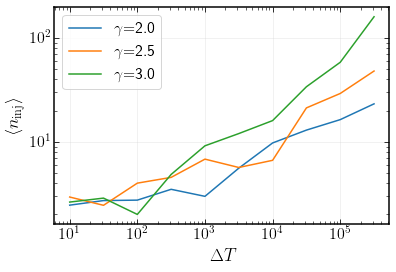

In [57]:
for gamma in gammas:
    plt.plot(delta_ts, event_sensitivity[gamma], label = f"$\gamma$={gamma}")
    
plt.ylabel(r'$\langle n_{\mathrm{inj}} \rangle $')
plt.xlabel('$\Delta T$')
    
plt.loglog()
plt.legend()
plt.show()

<ErrorbarContainer object of 3 artists>

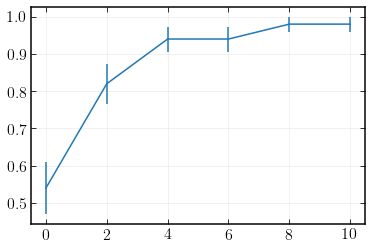

In [44]:
plt.errorbar(results[2.0][0]['info']['n_sigs'], results[2.0][0]['info']['CLs'], yerr= results[2.0][0]['info']['sigmas'])

In [21]:
results[2.0][0]

{'n_sig': 2.9855702252964758,
 'n_sig_error': 0.0,
 'n_sig_history': array([2.98557023]),
 'n_sig_error_history': array([0.]),
 'n_trials_history': [50],
 'info': {'n_sig': 2.9855702252964758,
  'n_sig_chi2cdf': inf,
  'n_sig_spline': 2.9855702252964758,
  'dof': 10,
  'loc': 0,
  'scale': 1.00000000002,
  'params': [10, 0, 1.00000000002],
  'spline': <scipy.interpolate._cubic.PchipInterpolator at 0x7f02acaec8f0>,
  'n_sigs': array([ 0.,  2.,  4.,  6.,  8., 10.]),
  'CLs': array([0.54, 0.82, 0.94, 0.94, 0.98, 0.98]),
  'sigmas': array([0.07048404, 0.05433231, 0.03358571, 0.03358571, 0.01979899,
         0.01979899]),
  'ts_threshold': 0.045346076980593786,
  'ts_from_fit': True,
  'ts_nsigma': 0,
  'ts_beta': 0.9},
 'tss': {0.0: array([6.45373904e-01, 3.87162585e-02, 8.04067049e-03, 1.64676609e-03,
         1.89553571e-01, 1.67813456e-01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.73402564e-01, 0.00000000e+00, 3.54194335e+00,
         0.00000000e+00, 4.00085352e+00, 7.8

In [4]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'

data_fs = sorted(glob(greco_base + 'IC86_20*data_with_angErr.npy'))
exp = [np.load(data) for data in data_fs]
exp = np.hstack(exp)
mc = np.load(greco_base + 'IC86_2012.numu_with_angErr.npy')
grls = sorted(glob(greco_base + 'GRL/IC86_20*data.npy'))
grl = [np.load(g) for g in grls]
grl = np.hstack(grl)

greco = cy.selections.CustomDataSpecs.CustomDataSpec(exp, mc, np.sum(grl['livetime']), 
                                                     np.linspace(-1., 1., 31),
                                                     np.linspace(0., 4., 31), 
                                                     grl=grl, key='GRECOv2.2', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/greco_ana')
greco_ana = cy.get_analysis(cy.selections.repo, greco, dir=ana_dir)

Setting up Analysis for:
GRECOv2.2
Setting up GRECOv2.2...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [5]:
tab = Table.read('/home/apizzuto/Nova/source_list/appendix.tex')
df = tab.to_pandas()
coords = SkyCoord(frame="galactic", l=df['$l$']*u.degree, b=df['$b$']*u.degree)
equatorial = coords.icrs
df['ra'] = equatorial.ra.deg
df['dec'] = equatorial.dec.deg
df['gamma'] = [~np.char.startswith(fl, '$<$') for fl in df['Flux']] 
df = df.replace(['-'], np.nan)
df[u'$t_2$'] = df[u'$t_2$'].astype(float)

In [6]:
max_time_window = 5.
#df = df[~df['gamma']]
df['$t_2$'][np.isnan(df['$t_2$'])] = max_time_window
df['mjd'] = np.array([Time(pt, '%Y-%m-%d').mjd for pt in df['Peak Time']])
during_greco = (df['mjd'] > greco_ana.mjd_min) & (df['mjd'] + df['$t_2$'] < greco_ana.mjd_max)
df = df[during_greco]

/home/apizzuto/.venvs/py3_realtime/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
ras = df['ra']
decs = df['dec']
delta_t = df['$t_2$']
delta_t = np.minimum(delta_t, np.ones_like(delta_t)*max_time_window)

conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
       }

src = cy.utils.Sources(ra=np.radians(ras), 
                       dec=np.radians(decs), 
                       mjd=df['mjd'], 
                       sigma_t=np.zeros_like(delta_t), 
                       t_100=delta_t)

cy.CONF['src'] = src
cy.CONF['mp_cpus'] = 10

tr = cy.get_trial_runner(conf, ana=greco_ana, src=src)
n_trials = 500
bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 500 background trials using 10 cores:
        500/500 trials complete.   
